# Simulaciones proyecto

En este notebook se desarrollan las simulaciones relacionadas al paper ...

Se busca probar los tests de hipótesis relacionados a la norma $L_1$ y la de $log$-Likelihood.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm

In [2]:
def samplear(distribution, params):
    return np.concatenate([distribution(**param, size=int(n_samples / len(params))) for param in params])

def transformar(l, u, a):
    l = np.array(l)
    u = np.array(u)
    a = np.array(a)
    return np.mean(l, axis=0), np.mean(u, axis=0), np.mean(a, axis=0)


## Estadístico basado en norma $L_1$

Primero se calcula el test basado en la norma $L_1$. Donde su formulación es:

$$
    L_1(\nu_n, \ \mu_{n,1} \times \mu_{n,2}) =
    \sum_{A\in P_n}\sum_{B\in Q_n} |\nu_n(A\times B) - \mu_{n,1}(A) \cdot \mu_{n,2}(B)|
$$
    
Donde se tiene que dicho estadístico sobrepasa un umbral dado por el test de hipótesis, que está dado por

$$
    L_{n}(\nu_{n}, \mu_{n,1}\times\mu_{n,2})>  c_{1}\left(\sqrt{\frac{m_{n} \cdot m'_{n}}{n}} + \sqrt{\frac{m_{n}}{n}} + \sqrt{\frac{m'_{n}}{n}}\right)  \approx c_{1}\sqrt{\frac{m_{n} \cdot m'_{n}}{n}}
$$

In [3]:
def l1Test(X, Y, mX, mY, plotear=False, asintotico=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)

    n_samples = X.shape[0]
    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    L1 = 0

    # el umbral
    if asintotico: umbral = 0.798 * np.sqrt((mX * mY) / n_samples)
    else: umbral = 1.177 * np.sqrt((mX * mY) / n_samples)

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X <= bx]) * np.array([X > ax])
            intervaloY = np.array([Y <= by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNY = np.sum(intervaloY) / n_samples

            aux = np.abs(nuN - muNX * muNY)
            L1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.vlines(bx, ymin=miny, ymax=maxy)
                plt.hlines(by, xmin=minx, xmax=maxx)
                plt.text(ax, ay, '{:.2f}'.format(aux))

    
    if plotear:
        print('L1 : {:.4f} umbral {:.4f}'.format(L1, umbral))

        if L1 < umbral: print('son independientes')
        else: print('son dependientes')
        print(mX / np.log(n_samples))
        print(mX * mY / n_samples)
        plt.show()
    return L1, umbral

## Estadístico basado en $log$-verosimilitud

La forma de este estadístico es:

$$
I_n(\nu_n,\mu_{n,1}\times\mu_{n,2}) = \sum_{A\in P_n}\sum_{B\in Q_n}\nu_n(A\times B)\log{\frac{\nu_n(A\times B)}{\mu_{n,1}(A)\cdot\mu_{n,2}(B)}}
$$

donde el umbral está definido por

$$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{m_nm'_n(\log{(n + m_nm'_n) + 1})}{n}
$$

<!-- $$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{\Phi^{-1} (1-\alpha) \sqrt{2m_{n} m'_{n}} + m_{n}m'_{n}}{2n}
$$
 -->

In [4]:
def logLikTest(X, Y, mX, mY, plotear=False, asintotico=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)
    
    n_samples = X.shape[0]
    
    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    I1 = 0

    # el umbral
    
    if asintotico:
        Nalpha = norm.pdf(1 - alpha)
        umbral = (Nalpha * np.sqrt(2 * mX * mY) + mX * mY) / n_samples
    else: umbral = mX * mY * (np.log(n_samples + mX * mY) + 1) / (2 * n_samples)
    
    eps = 1e-16

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X <= bx]) * np.array([X > ax])
            intervaloY = np.array([Y <= by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNY = np.sum(intervaloY) / n_samples
            
            if nuN == 0: aux = 0
            else: aux = nuN * np.log(nuN / (muNX * muNY + eps))
            I1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.xlabel('X'), plt.ylabel('Y')
#                 plt.vlines(bx, ymin=miny, ymax=maxy)
#                 plt.hlines(by, xmin=minx, xmax=maxx)
#                 plt.text(ax, ay, '{:.2f}'.format(aux))


    if plotear:
        print('I1 : {:.4f} umbral {:.4f}'.format(I1, umbral))

        if I1 < umbral: print('son independientes')
        else: print('son dependientes')

        print('Condicion : {:.4f}'.format(mX * mY / n_samples * np.log(n_samples + mX * mY)))
        plt.show()
    return I1, umbral

In [5]:
def run(distribution, paramsX, paramsY, func=logLikTest, asintotico=False):
    estadistico = []
    umbral = []
    acceptance = []

    for theta in Theta:

        rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                                   [np.sin(theta), np.cos(theta)]])

        acc = []
        umbral_ = []
        est = []
        
        print('\r theta : {:.2f}'.format(theta), end='', flush=True)
            
        theta = theta * np.pi / 4

        for semilla in range(N):
            np.random.seed(semilla)
            
            X = samplear(distribution, paramsX)
            Y = samplear(distribution, paramsY)

            [X, Y] = rotationMatrix @ [X, Y]

            test, u = func(X, Y, mX, mY, plotear=plotear, asintotico=asintotico)
            est.append(test)
            umbral_.append(u)
            acc.append(test <= u)

        estadistico.append(np.mean(est))
        umbral.append(np.mean(umbral_))
        acceptance.append(np.mean(acc))
    
    return [estadistico, umbral, acceptance]

    

Simulaciones

In [6]:
# parametros
d = 1
n_samples = 1024

mX = 4
mY = 4
alpha = 0.05

Theta = np.linspace(0, 1, num=20)

N = 100
plotear = False


Como calcular la curtosis de una distribución

$$K = \frac{\mu_4}{\sigma^4}$$

donde $\mu_4$ es la media del cuarto momento de la distribución, es decir, $E((X - E(X))^4) = \mu_4$. Pero en este caso, se tomará solamente como la media de la distribución, es decir

$$K' = \frac{\mu}{\sigma^4}$$

Y se usará este término para dar forma a las distribuciones a utilizar.

Distribuciones que se deben considerar

|Label|Definition|Kurtosis|Params|
|-----|----------|--------|------|
|a|Student’s t distribution, 3 DOF|∞|3 dof|
|b|Double exponential|3.00|loc = 3, scale = 1|
|c|Uniform|-1.20|cualquiera|
|d|Students’s t distribution, 5 DOF|6.00|5 dof| 
|e|Exponential|6.00|scale = 1 / 6| 
|f|Mixture, 2 double exponentials|-1.70|loc = {10, 2}, scale = 1|
|g|Symmetric mixture 2 Gauss., multimodal|-1.85||
|h|Symmetric mixture 2 Gauss., transitional|-0.75||
|i|Symmetric mixture 2 Gauss., unimodal|-0.50||
|j|Asymm. mixture 2 Gauss., multimodal|-0.57||
|k|Asymm. mixture 2 Gauss., transitional|-0.29|| 
|l|Asymm. mixture 2 Gauss., unimodal|-0.20||
|m|Symmetric mixture 4 Gauss., multimodal|-0.91||
|n|Symmetric mixture 4 Gauss., transitional|-0.34||
|o|Symmetric mixture 4 Gauss., unimodal|-0.40||
|p|Asymm. mixture 4 Gauss., multimodal|-0.67||
|q|Asymm. mixture 4 Gauss., transitional|-0.59||
|r|Asymm. mixture 4 Gauss., unimodal|-0.82||


double exponential 1
I1 : 0.0022 umbral 0.0621
son independientes
Condicion : 0.1085


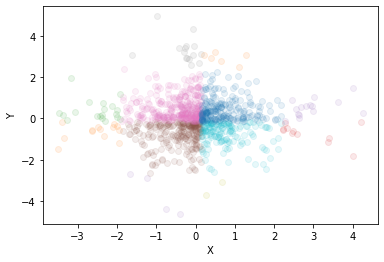

L1 : 0.0141 umbral 0.1471
son independientes
0.5770780163555853
0.015625


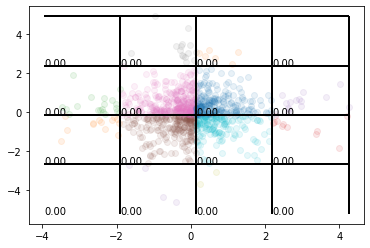

uniform
I1 : 0.0031 umbral 0.0621
son independientes
Condicion : 0.1085


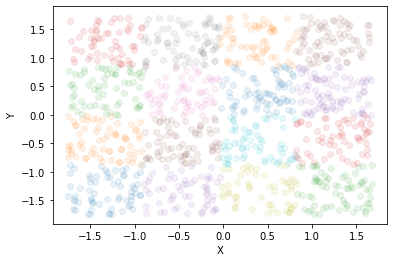

L1 : 0.0679 umbral 0.1471
son independientes
0.5770780163555853
0.015625


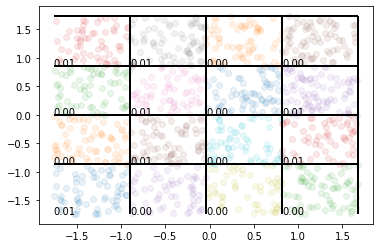

t-student
I1 : 0.0079 umbral 0.0621
son independientes
Condicion : 0.1085


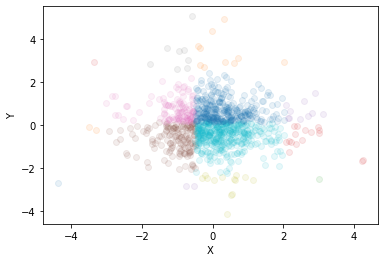

L1 : 0.0203 umbral 0.1471
son independientes
0.5770780163555853
0.015625


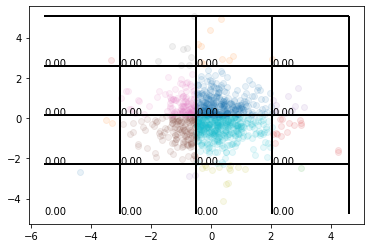

exponential
I1 : 0.0044 umbral 0.0621
son independientes
Condicion : 0.1085


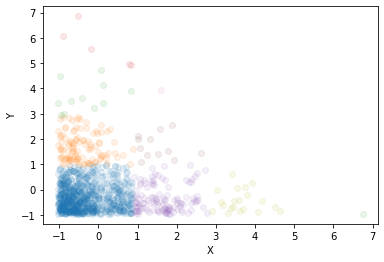

L1 : 0.0292 umbral 0.1471
son independientes
0.5770780163555853
0.015625


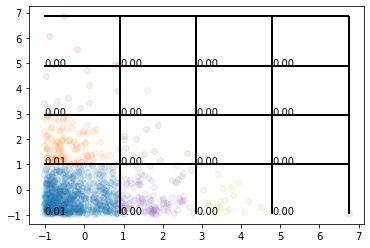

double exponential 1
I1 : 0.0110 umbral 0.0621
son independientes
Condicion : 0.1085


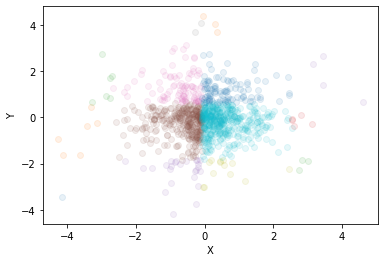

L1 : 0.0642 umbral 0.1471
son independientes
0.5770780163555853
0.015625


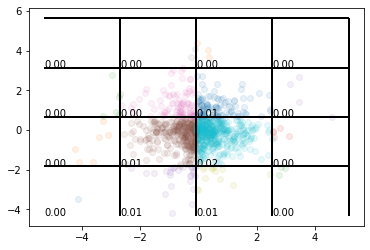

gaussian mixture 2
I1 : 0.0030 umbral 0.0621
son independientes
Condicion : 0.1085


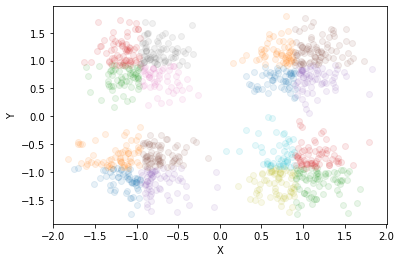

L1 : 0.0621 umbral 0.1471
son independientes
0.5770780163555853
0.015625


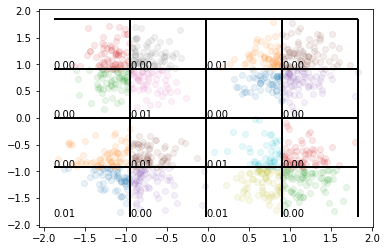

gaussian mixture 3
I1 : 0.0025 umbral 0.0621
son independientes
Condicion : 0.1085


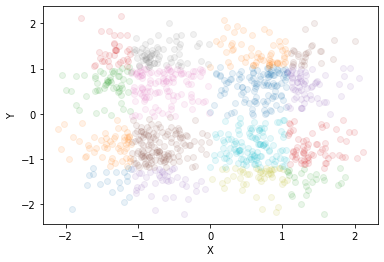

L1 : 0.0541 umbral 0.1471
son independientes
0.5770780163555853
0.015625


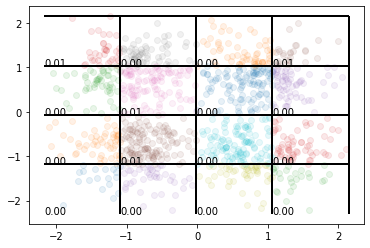

chisquare
I1 : 0.0024 umbral 0.0621
son independientes
Condicion : 0.1085


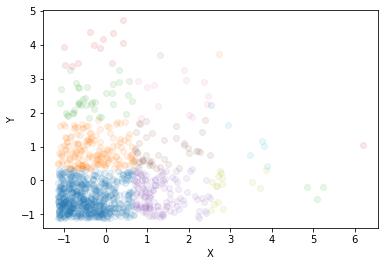

L1 : 0.0325 umbral 0.1471
son independientes
0.5770780163555853
0.015625


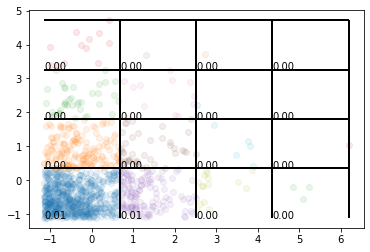

In [7]:
distributions = [
    ['double exponential 1', np.random.laplace,
     [{'loc':3, 'scale':3}],
     [{'loc':3, 'scale':3}]],
    ['uniform', np.random.uniform,
     [{'low': -3, 'high': 6}],
     [{'low': -1, 'high': 3}]],
    ['t-student', np.random.standard_t,
     [{'df': 5}],
     [{'df': 5}]],
    ['exponential', np.random.exponential,
     [{'scale': 1}],
     [{'scale': 1}]],
    ['double exponential 1', np.random.laplace,
     [{'loc': 2, 'scale':1}],
     [{'loc': 2, 'scale':1}]],
    ['gaussian mixture 2', np.random.normal,
     [{'loc':-3, 'scale': 1},
      {'loc': 3, 'scale': 1},
      {'loc':-3, 'scale': 1},
      {'loc': 3, 'scale': 1}],
     [{'loc':-3, 'scale': 1},
      {'loc':-3, 'scale': 1},
      {'loc': 3, 'scale': 1},
      {'loc': 3, 'scale': 1}]],
    ['gaussian mixture 3', np.random.normal,
     [{'loc': -2, 'scale': 1},
      {'loc': -2, 'scale': 1},
      {'loc':  2, 'scale': 1},
      {'loc':  2, 'scale': 1}],
     [{'loc': -2, 'scale': 1},
      {'loc':  2, 'scale': 1},
      {'loc': -2, 'scale': 1},
      {'loc':  2, 'scale': 1}]],
    ['chisquare', np.random.chisquare,
     [{'df': 3},
      {'df': 2},
      {'df': 4},
      {'df': 2}],
     [{'df': 3},
      {'df': 2},
      {'df': 4},
      {'df': 2}]],
]

theta = 0
rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                       [np.sin(theta), np.cos(theta)]])

for name, distribution, paramsX, paramsY in distributions:
    print('{}'.format(name))


    X = samplear(distribution, paramsX)
    Y = samplear(distribution, paramsY)
    
    X, Y = rotationMatrix @ [X, Y]
    
    I1, umbral = logLikTest(X, Y, mX, mY, plotear=True)
    L1, umbral = l1Test(X, Y, mX, mY, plotear=True)

double exponential 1
 theta : 1.00
uniform
 theta : 1.00
t-student
 theta : 1.00
exponential
 theta : 1.00
double exponential 1
 theta : 1.00
gaussian mixture 2
 theta : 1.00
gaussian mixture 3
 theta : 1.00
chisquare
 theta : 1.00


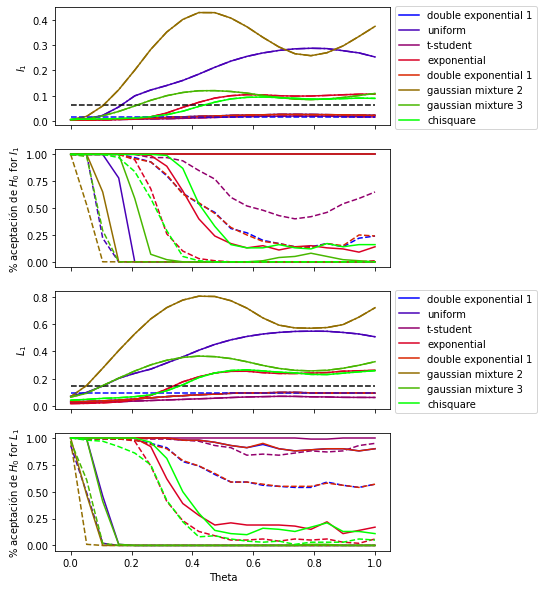

In [8]:
L1, umbralL1, acceptanceL1 = [], [], []
I1, umbralI1, acceptanceI1 = [], [], []
L1_alpha, umbralL1_alpha, acceptanceL1_alpha = [], [], []
I1_alpha, umbralI1_alpha, acceptanceI1_alpha = [], [], []

fig, axs = plt.subplots(4, sharex=True, figsize=(6,10))
# fig.suptitle('Resultados por distribucion')
axs[0].set_ylabel('$I_1$')
axs[1].set_ylabel('% aceptación de $H_0$ for $I_1$')
axs[2].set_ylabel('$L_1$')
axs[3].set_ylabel('% aceptación de $H_0$ for $L_1$')
axs[3].set_xlabel('Theta')

colors = cm.brg(np.linspace(0, 1, len(distributions)))
labels = []
i = 0

for name, distribution, paramsX, paramsY in distributions:
    print('{}'.format(name))
    labels.append(name)
    I1_,  uI1,  accI1  = run(distribution, paramsX, paramsY, logLikTest)
    L1_,  uL1,  accL1  = run(distribution, paramsX, paramsY, l1Test)

    I1_a, uI1a, accI1a = run(distribution, paramsX, paramsY, logLikTest, True)
    L1_a, uL1a, accL1a = run(distribution, paramsX, paramsY, l1Test, True)
     
    axs[0].plot(Theta, I1_, ls='solid', color=colors[i], label=name)
    axs[0].plot(Theta, I1_a, ls='-.', color=colors[i])
    axs[0].plot(Theta, uI1, ls='dashed', c='k', alpha=0.2)
    axs[0].plot(Theta, uI1a, ls='dashed', c='b', alpha=0.2)
    axs[1].plot(Theta, accI1, color=colors[i])
    axs[1].plot(Theta, accI1a, color=colors[i], ls='dashed')

    axs[2].plot(Theta, L1_, ls='solid', color=colors[i], label=name)
    axs[2].plot(Theta, L1_a, ls='-.', color=colors[i])
    axs[2].plot(Theta, uL1, ls='dashed', c='k', alpha=0.2)
    axs[2].plot(Theta, uL1a, ls='dashed', c='b', alpha=0.2)
    axs[3].plot(Theta, accL1, color=colors[i])
    axs[3].plot(Theta, accL1a, color=colors[i], ls='dashed')

    i += 1
    
    I1.append(I1_), umbralI1.append(uI1), acceptanceI1.append(accI1)
    L1.append(L1_), umbralL1.append(uL1), acceptanceL1.append(accL1)

    I1_alpha.append(I1_a), umbralI1_alpha.append(uI1a), acceptanceI1_alpha.append(accI1a)
    L1_alpha.append(L1_a), umbralL1_alpha.append(uL1a), acceptanceL1_alpha.append(accL1a)
    
    print()

axs[0].legend(bbox_to_anchor=(1, 1.05))
axs[2].legend(bbox_to_anchor=(1, 1.05))
plt.show()

L1, umbralL1, acceptanceL1 = transformar(L1, umbralL1, acceptanceL1)
I1, umbralI1, acceptanceI1 = transformar(I1, umbralI1, acceptanceI1)

L1_alpha, umbralL1_alpha, acceptanceL1_alpha = transformar(L1_alpha, umbralL1_alpha, acceptanceL1_alpha)
I1_alpha, umbralI1_alpha, acceptanceI1_alpha = transformar(I1_alpha, umbralI1_alpha, acceptanceI1_alpha)


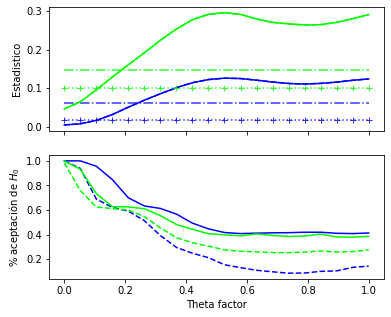

In [9]:
fig, axs = plt.subplots(2, sharex=True, figsize=(6,5))
# fig.suptitle('Resultados agregados')
axs[0].set_ylabel('Estadistico')
axs[1].set_ylabel('% aceptación de $H_0$')
axs[1].set_xlabel('Theta factor')

axs[0].plot(Theta, I1, label='$I_1$', color=colors[0])
axs[0].plot(Theta, I1_alpha, ls='--', label='$I_1$ alpha-level', color=colors[0])
axs[0].plot(Theta, umbralI1, label='umbral $I_1$', ls='-.', color=colors[0], alpha=0.8)
axs[0].plot(Theta, umbralI1_alpha, label='umbral $I_1$ alpha-level',
            ls=':', marker='+', color=colors[0], alpha=0.8)
axs[1].plot(Theta, acceptanceI1, color=colors[0])
axs[1].plot(Theta, acceptanceI1_alpha, color=colors[0], ls='--')

axs[0].plot(Theta, L1, label='$L_1$', color=colors[-1])
axs[0].plot(Theta, L1_alpha, ls='--', label='$L_1$ alpha-level', color=colors[-1])
axs[0].plot(Theta, umbralL1, label='umbral $L_1$', ls='-.', color=colors[-1], alpha=0.8)
axs[0].plot(Theta, umbralL1_alpha, label='umbral $L_1$ alpha-level',
            ls=':', marker='+', color=colors[-1], alpha=0.8)
axs[1].plot(Theta, acceptanceL1, color=colors[-1])
axs[1].plot(Theta, acceptanceL1_alpha, color=colors[-1], ls='--')

# axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#            ncol=2, mode="expand", borderaxespad=0.)
# axs[1].legend()
plt.show()

(1024,)


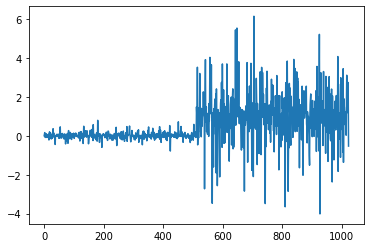

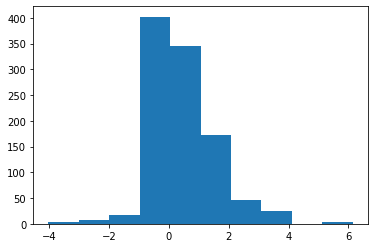

((array([  4.,   8.,  18., 402., 345., 172.,  46.,  25.,   0.,   4.]),
  array([-4.01453689, -2.99875443, -1.98297198, -0.96718952,  0.04859293,
          1.06437539,  2.08015784,  3.0959403 ,  4.11172275,  5.12750521,
          6.14328767]),
  <a list of 10 Patch objects>),
 None)

In [10]:
distribution = np.random.laplace
params = [{'loc':0, 'scale':0.1},
          {'loc':1, 'scale':  1}]

x = samplear(distribution, params)
print(x.shape)
plt.plot(x), plt.show()
plt.hist(x), plt.show()

In [11]:
aa = []
aa.append(np.array([1, 2, 3, 4]))
aa.append(np.array([1, 2, 3, 4]))
aa = np.array(aa)

print(np.mean(aa, axis=0))

[1. 2. 3. 4.]


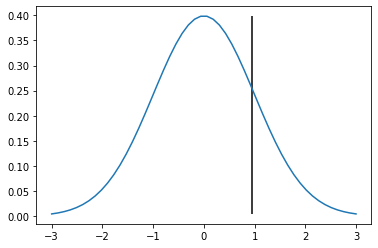

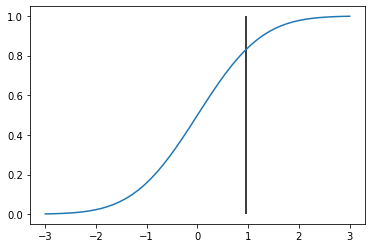

([<matplotlib.lines.Line2D at 0x7f98ddc3c490>],
 None)

In [12]:
x = np.linspace(-3,3)
alpha = 0.05
plt.plot(x, norm.pdf(x)), plt.vlines(1 - alpha, max(norm.pdf(x)), min(norm.pdf(x))), plt.show()
plt.plot(x, norm.cdf(x)), plt.vlines(1 - alpha, max(norm.cdf(x)), min(norm.cdf(x))), plt.show()


In [13]:
a, b, c = 3, 2, 1

In [14]:
c

1

In [15]:
mX * mY / n_samples * np.log(n_samples + mX * mY)

0.10854649987711591